## Script de Clasificación Cuántica vs Clásica en Física de Altas Energías (HEP)

**Dataset:** SUSY (Supersymmetry) del UCI Machine Learning Repository  
**Objetivo:** Clasificación de eventos para identificar la generación de partículas supersimétricas (signal) o partículas del modelo estándar (background).


In [1]:
# ============================================================================
# 0. IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN
# ============================================================================

import numpy as np
import pandas as pd
import gzip
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

# Qiskit (versión moderna)
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal, RealAmplitudes, PauliFeatureMap
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms import VQC, QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel, TrainableKernel
from qiskit_aer import AerSimulator

# Semilla global
algorithm_globals.random_seed = 42
np.random.seed(42)

In [2]:
# ============================================================================
# 0.1. VERIFICACIÓN DE VERSIONES
# ============================================================================

import qiskit
import qiskit_machine_learning
import qiskit_algorithms
import sklearn

print("Versión de qiskit:", qiskit.__version__)
print("Versión de qiskit-machine-learning:", qiskit_machine_learning.__version__)
print("Versión de qiskit-algorithms:", qiskit_algorithms.__version__)
print("Versión de scikit-learn:", sklearn.__version__)
print("Versión de numpy:", np.__version__)
print("Versión de pandas:", pd.__version__)

Versión de qiskit: 1.2.4
Versión de qiskit-machine-learning: 0.7.2
Versión de qiskit-algorithms: 0.3.0
Versión de scikit-learn: 1.5.2
Versión de numpy: 1.26.4
Versión de pandas: 2.2.2


In [3]:
# ============================================================================
# 1. CARGA Y PREPARACIÓN INICIAL DE DATOS (SUSY)
# ============================================================================

# Ruta del archivo SUSY completo (50k eventos)
file_path = r'C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\Computación Cuántica - INF465\susy\SUSY.csv.gz'

# Nombres de columnas (adaptado a tu notación)
column_names = [
    'label',
    'lepton1_pT', 'lepton1_eta', 'lepton1_phi',
    'lepton2_pT', 'lepton2_eta', 'lepton2_phi',
    'missing_energy_magnitude', 'missing_energy_phi',
    'MET_rel', 'axial_MET', 'M_R', 'M_TR_2', 'R',
    'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos_theta_r1'
]

# Número de filas a cargar (similar a Terashi pero más grande)
N_ROWS_TO_LOAD = 50000

df = pd.read_csv(
    file_path,
    compression='gzip',
    names=column_names,
    nrows=N_ROWS_TO_LOAD
)

print(f"Dataset cargado exitosamente: {df.shape[0]} muestras, {df.shape[1]-1} características")
print(f"  - Señal (label=1): {(df['label']==1).sum()} muestras")
print(f"  - Fondo (label=0): {(df['label']==0).sum()} muestras")

df.head()

Dataset cargado exitosamente: 50000 muestras, 18 características
  - Señal (label=1): 23008 muestras
  - Fondo (label=0): 26992 muestras


,label,lepton1_pT,lepton1_eta,lepton1_phi,lepton2_pT,lepton2_eta,lepton2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


| Variable                   | Descripción                                                                                   |
|----------------------------|----------------------------------------------------------------------------------------------|
| `label`                    | Etiqueta de clase: 1 = Evento señal (SUSY), 0 = Evento fondo (Standard Model)                |
| `lepton1_pT`               | Momento transversal del primer leptón                                                         |
| `lepton1_eta`              | Pseudorapidez del primer leptón                                                              |
| `lepton1_phi`              | Ángulo azimutal del primer leptón                                                            |
| `lepton2_pT`               | Momento transversal del segundo leptón                                                       |
| `lepton2_eta`              | Pseudorapidez del segundo leptón                                                             |
| `lepton2_phi`              | Ángulo azimutal del segundo leptón                                                           |
| `missing_energy_magnitude` | Magnitud de la energía faltante (MET, Missing Transverse Energy)                             |
| `missing_energy_phi`       | Ángulo azimutal de la energía faltante                                                       |
| `MET_rel`                  | Energía transversal faltante relativa                                                        |
| `axial_MET`                | Componente axial de la energía faltante                                                      |
| `M_R`                      | Variable de masa relacionada con la reconstrucción de eventos                                |
| `M_TR_2`                   | Variable de masa transversal (versión 2)                                                     |
| `R`                        | Variable de razón utilizada en la discriminación de eventos                                  |
| `MT2`                      | Variable de masa transversal para dos partículas                                             |
| `S_R`                      | Variable relacionada con la suma de razones                                                  |
| `M_Delta_R`                | Diferencia de masa en función de la distancia en el espacio de parámetros                    |
| `dPhi_r_b`                 | Diferencia de ángulo azimutal entre objetos relevantes                                      |
| `cos_theta_r1`             | Coseno del ángulo polar de uno de los objetos reconstruidos                                 |

> **Nota:** Todas las variables corresponden a características físicas extraídas de eventos simulados en colisionadores, utilizadas para distinguir entre procesos estándar y supersimétricos.

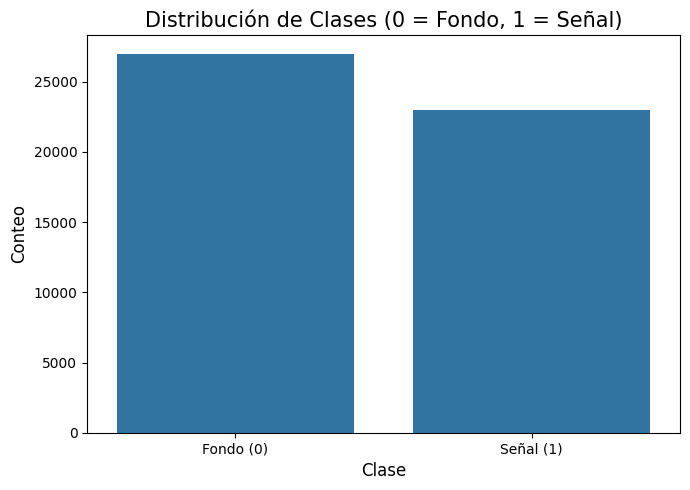

In [4]:
# ============================================================================
# 1.1. ANÁLISIS EXPLORATORIO BÁSICO
# ============================================================================

plt.figure(figsize=(7, 5))
sns.countplot(x='label', data=df)
plt.title('Distribución de Clases (0 = Fondo, 1 = Señal)', fontsize=15)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Conteo', fontsize=12)
plt.xticks([0, 1], ['Fondo (0)', 'Señal (1)'])
plt.tight_layout()
plt.show()

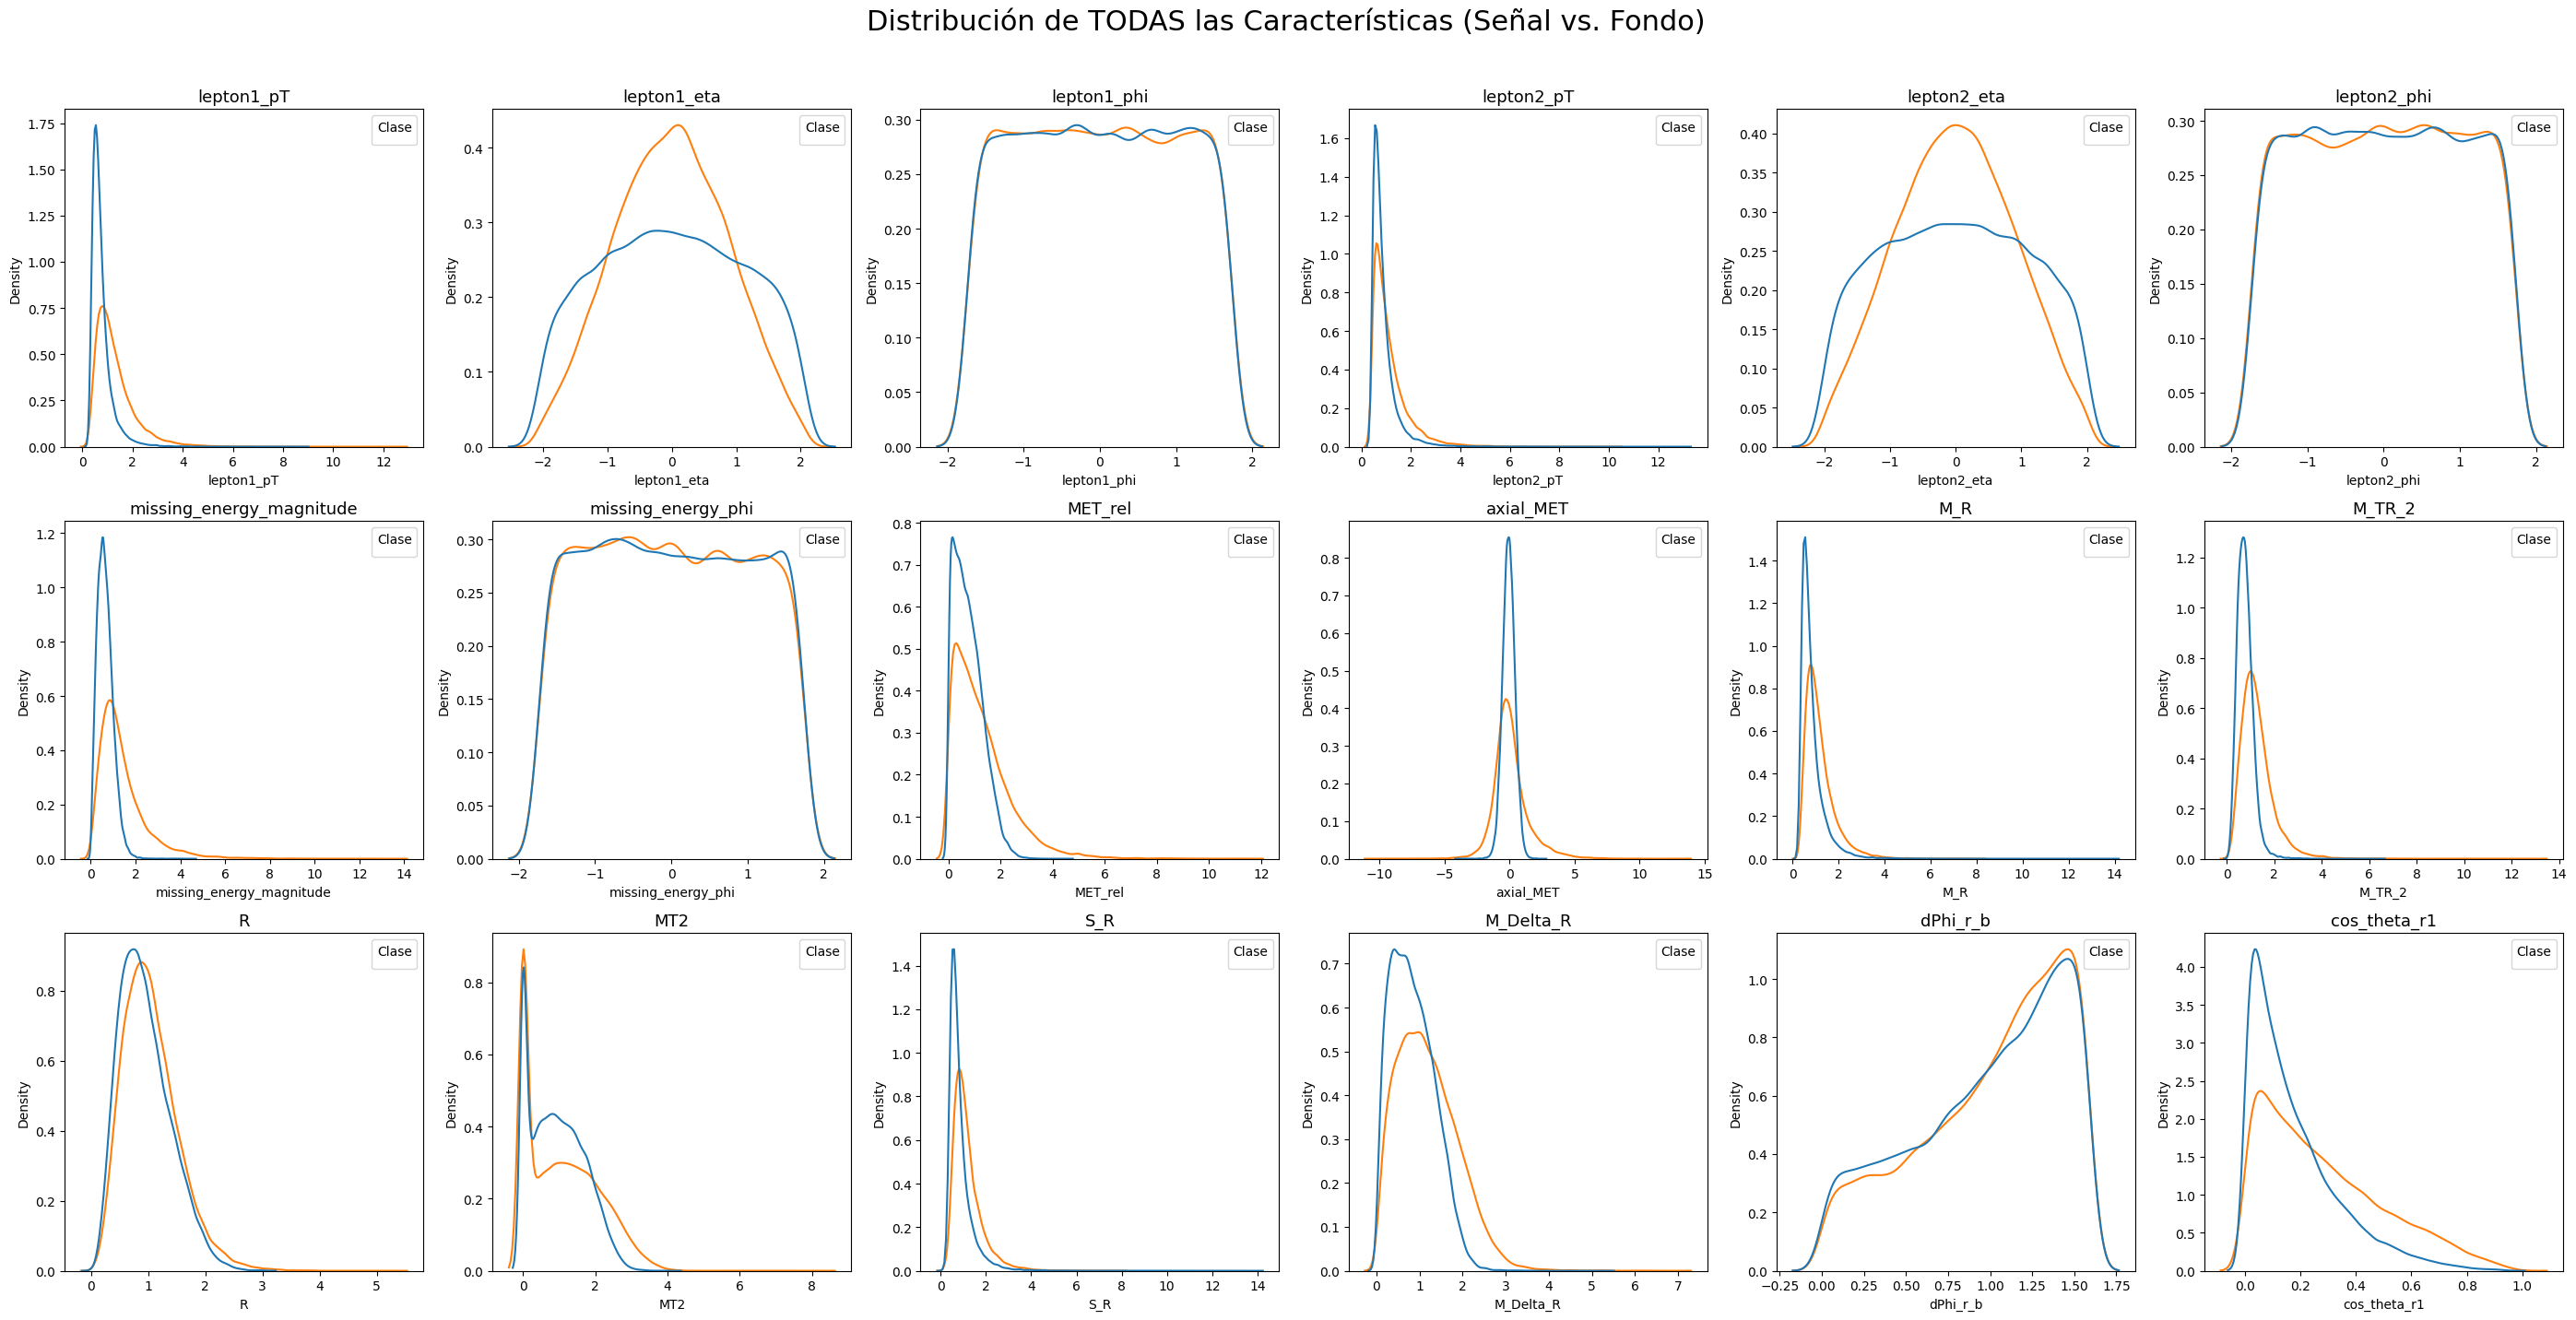

In [5]:
all_features = df.columns.drop('label')
fig, axes = plt.subplots(3, 6, figsize=(28, 14))
fig.suptitle('Distribución de TODAS las Características (Señal vs. Fondo)', fontsize=22, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(all_features):
    sns.kdeplot(data=df, x=feature, hue='label', ax=axes[i], common_norm=False)
    axes[i].set_title(f'{feature}', fontsize=13)
    legend = axes[i].get_legend()
    if legend is not None:
        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].legend(handles, ['Señal (1)', 'Fondo (0)'], title='Clase')
    else:
        # No leyenda, no hacer nada
        pass

# Oculta los ejes vacíos si hay menos de 18 features
for j in range(len(all_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('feature_kde_all.png')

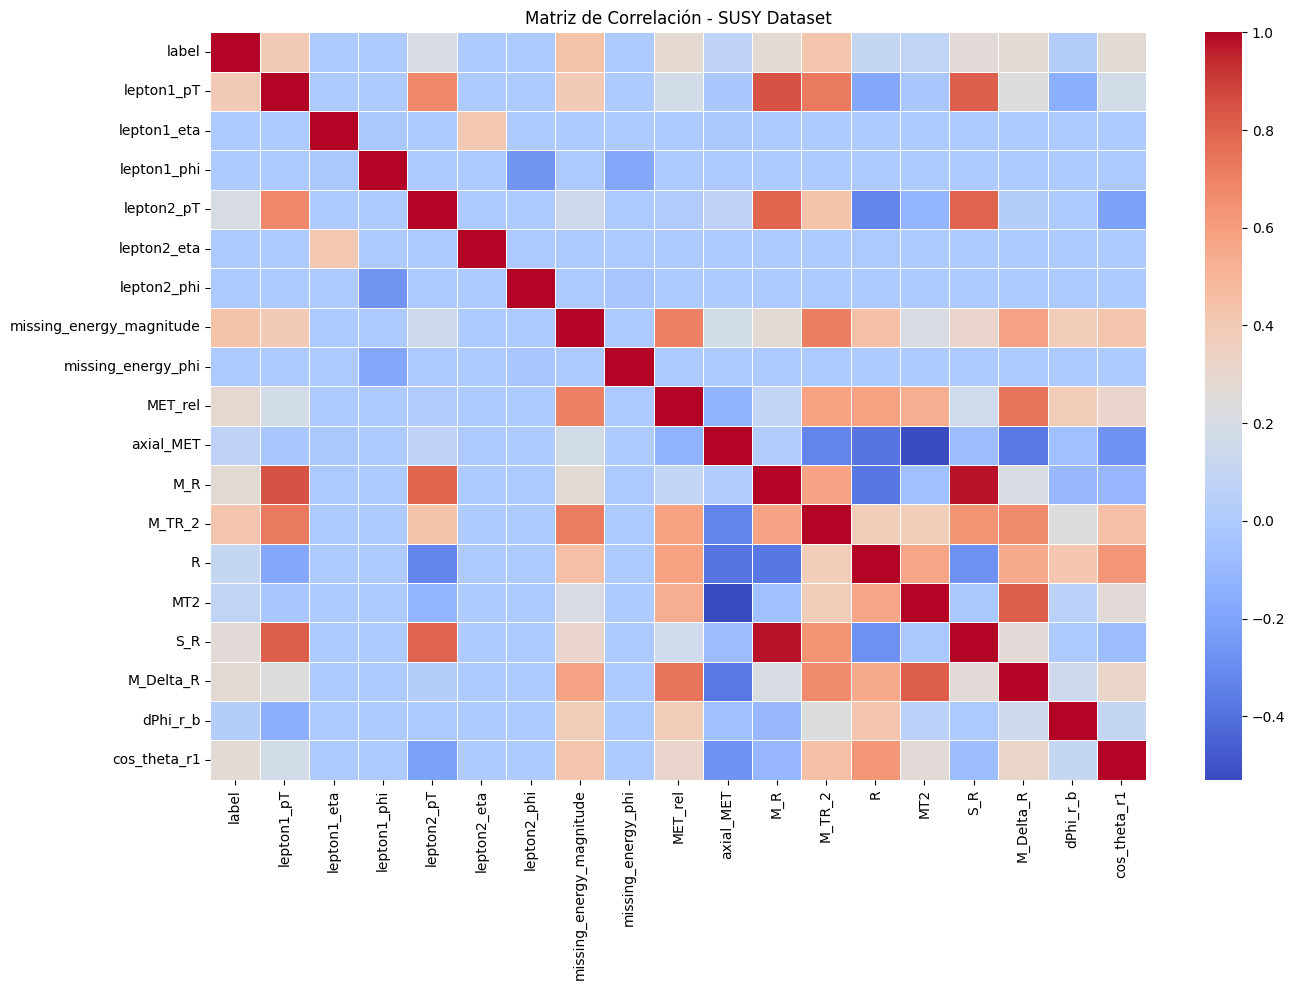

In [6]:
# Matriz de correlación
corr_matrix = df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación - SUSY Dataset")
plt.tight_layout()
plt.show()

In [7]:
# Correlación de cada variable con la etiqueta
corr_label = corr_matrix['label'].drop('label').abs().sort_values(ascending=False)

tabla_corr_completa = pd.DataFrame({
    'Variable': corr_label.index,
    'Correlación absoluta con label': corr_label.values
})

display(tabla_corr_completa)

,Variable,Correlación absoluta con label
0,missing_energy_magnitude,0.436775
1,M_TR_2,0.422959
2,lepton1_pT,0.394117
3,MET_rel,0.283381
4,M_Delta_R,0.273180
5,M_R,0.272100
6,cos_theta_r1,0.268426
7,S_R,0.262015
8,lepton2_pT,0.200238
9,R,0.107778


In [8]:
# ============================================================================
# 2. SELECCIÓN DE FEATURES MEJORADA (Basada en Correlación)
# ============================================================================

# Opción 1: Selección manual de las top features correlacionadas
# Basado en tu análisis de correlación, usar las más discriminativas
#selected_features = ['axial_MET', 'MET_rel', 'missing_energy_magnitude', 'M_R']

# Opción 2: Selección automática de top N features
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=3)
X_temp = selector.fit_transform(df.drop('label', axis=1), df['label'])
selected_features = df.drop('label', axis=1).columns[selector.get_support()].tolist()

feature_dim = len(selected_features)
print("=" * 70)
print("CONFIGURACIÓN DE FEATURES PARA MODELOS CUÁNTICOS")
print("=" * 70)
print(f"Features seleccionadas: {selected_features}")
print(f"Dimensión de features (n_qubits): {feature_dim}")
print("=" * 70)

# Extraer X e y sólo con estas features
X_raw = df[selected_features].values
y_raw = df['label'].values

# Normalización (StandardScaler) como paso único previo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

print(f"\nShape de X_scaled: {X_scaled.shape}")
print(f"Rango de valores normalizados: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")

CONFIGURACIÓN DE FEATURES PARA MODELOS CUÁNTICOS
Features seleccionadas: ['lepton1_pT', 'missing_energy_magnitude', 'M_TR_2']
Dimensión de features (n_qubits): 3

Shape de X_scaled: (50000, 3)
Rango de valores normalizados: [-1.69, 20.74]


In [9]:
# ============================================================================
# 3. CONJUNTOS BALANCEADOS Y SPLITS TRAIN / VALIDATION / TEST
#    MEJORADO: Más muestras para modelos cuánticos
# ============================================================================

# Separar señal y fondo
df_sig = df[df['label'] == 1]
df_bkg = df[df['label'] == 0]

# INCREMENTADO: Más eventos por clase para mejor entrenamiento
NEVT_PER_CLASS = 250  # Aumentado de 250 a 500 (puedes subir a 1000 si el tiempo lo permite)

df_sig_sample = df_sig.sample(n=NEVT_PER_CLASS, random_state=42)
df_bkg_sample = df_bkg.sample(n=NEVT_PER_CLASS, random_state=42)

df_bal = pd.concat([df_sig_sample, df_bkg_sample]).sample(frac=1.0, random_state=42).reset_index(drop=True)

# Usamos las mismas features seleccionadas
X_bal = df_bal[selected_features].values
y_bal = df_bal['label'].values

# Normalización sobre este conjunto balanceado
scaler_bal = StandardScaler()
X_bal_scaled = scaler_bal.fit_transform(X_bal)

print("=" * 70)
print("CONJUNTO DE DATOS BALANCEADO")
print("=" * 70)
print(f"Total muestras: {X_bal_scaled.shape[0]}")
print(f"  - Señal (1): {(y_bal == 1).sum()} muestras")
print(f"  - Fondo (0): {(y_bal == 0).sum()} muestras")
print(f"  - Balance: {(y_bal == 1).sum() / len(y_bal) * 100:.1f}% señal")
print("=" * 70)

# Splits: train / validation / test (60% / 20% / 20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_bal_scaled, y_bal,
    test_size=0.2,
    random_state=42,
    stratify=y_bal
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,   # 0.25 de 0.8 -> 0.2 total
    random_state=42,
    stratify=y_temp
)

print("\nSplits finales:")
print(f"  - Train:      {X_train.shape[0]} muestras ({X_train.shape[0]/len(y_bal)*100:.1f}%)")
print(f"  - Validation: {X_val.shape[0]} muestras ({X_val.shape[0]/len(y_bal)*100:.1f}%)")
print(f"  - Test:       {X_test.shape[0]} muestras ({X_test.shape[0]/len(y_bal)*100:.1f}%)")
print("=" * 70)

CONJUNTO DE DATOS BALANCEADO
Total muestras: 500
  - Señal (1): 250 muestras
  - Fondo (0): 250 muestras
  - Balance: 50.0% señal

Splits finales:
  - Train:      300 muestras (60.0%)
  - Validation: 100 muestras (20.0%)
  - Test:       100 muestras (20.0%)


In [10]:
# ============================================================================
# 4. MODELO CLÁSICO - SVM-RBF (Baseline)
# ============================================================================

svm_classical = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

start_time = time.time()
svm_classical.fit(X_train, y_train)
classical_train_time = time.time() - start_time

print(f"Modelo SVM clásico entrenado en {classical_train_time:.4f} segundos")

# Predicciones
y_pred_train_cl = svm_classical.predict(X_train)
y_pred_val_cl = svm_classical.predict(X_val)
y_pred_test_cl = svm_classical.predict(X_test)

y_proba_val_cl = svm_classical.predict_proba(X_val)[:, 1]
y_proba_test_cl = svm_classical.predict_proba(X_test)[:, 1]

# Métricas
acc_train_cl = accuracy_score(y_train, y_pred_train_cl)
acc_val_cl = accuracy_score(y_val, y_pred_val_cl)
acc_test_cl = accuracy_score(y_test, y_pred_test_cl)

auc_val_cl = roc_auc_score(y_val, y_proba_val_cl)
auc_test_cl = roc_auc_score(y_test, y_proba_test_cl)

print("\nRESULTADOS SVM CLÁSICO:")
print(f"  - Accuracy (Train): {acc_train_cl:.4f}")
print(f"  - Accuracy (Val):   {acc_val_cl:.4f}")
print(f"  - Accuracy (Test):  {acc_test_cl:.4f}")
print(f"  - AUC (Val):        {auc_val_cl:.4f}")
print(f"  - AUC (Test):       {auc_test_cl:.4f}")

Modelo SVM clásico entrenado en 0.0110 segundos

RESULTADOS SVM CLÁSICO:
  - Accuracy (Train): 0.7700
  - Accuracy (Val):   0.7900
  - Accuracy (Test):  0.8600
  - AUC (Val):        0.8324
  - AUC (Test):       0.9296


CONFIGURACIÓN DEL MODELO QSVM
Número de qubits: 3
Feature Map: ZZFeatureMap
  - Reps: 2
  - Entanglement: full
  - Número de parámetros: 3
  - Profundidad del circuito: 11
  - Número de puertas: 15

Visualizando Feature Map...


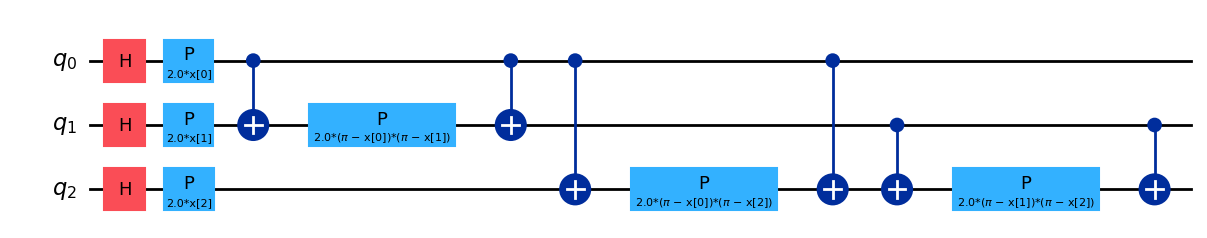

In [11]:
# ============================================================================
# 5. MODELO CUÁNTICO - QSVM MEJORADO
#    Feature map más expresivo con mayor entrelazamiento
# ============================================================================

n_qubits = feature_dim  # número de features = número de qubits

print("=" * 70)
print("CONFIGURACIÓN DEL MODELO QSVM")
print("=" * 70)
print(f"Número de qubits: {n_qubits}")

# OPCIÓN 1: ZZFeatureMap mejorado (MÁS EXPRESIVO)
feature_map_qsvm = ZZFeatureMap(
    feature_dimension=n_qubits,
    reps=1,  # Aumentado de 1 a 2 para mayor expresividad
    entanglement='full',  # Cambiado de 'linear' a 'full' para mejor entrelazamiento
    insert_barriers=False
)

# OPCIÓN 2: PauliFeatureMap (Descomenta para probar alternativa más potente)
# feature_map_qsvm = PauliFeatureMap(
#     feature_dimension=n_qubits,
#     reps=1,
#     paulis=['Z', 'ZZ', 'ZZZ'],  # Productos de Pauli de distinto orden
#     entanglement='full'
# )

print(f"Feature Map: ZZFeatureMap")
print(f"  - Reps: 2")
print(f"  - Entanglement: full")
print(f"  - Número de parámetros: {feature_map_qsvm.num_parameters}")
print(f"  - Profundidad del circuito: {feature_map_qsvm.decompose().depth()}")
print(f"  - Número de puertas: {feature_map_qsvm.decompose().size()}")
print("=" * 70)

# Crear kernel cuántico
quantum_kernel = FidelityQuantumKernel(
    feature_map=feature_map_qsvm
)

# Modelo QSVC
qsvm = QSVC(
    quantum_kernel=quantum_kernel,
    random_state=42
)

# Visualizar circuito
print("\nVisualizando Feature Map...")
feature_map_qsvm.decompose().draw(output="mpl")

In [12]:
print("=" * 70)
print("ENTRENANDO MODELO QSVM...")
print("=" * 70)

start_time = time.time()
qsvm.fit(X_train, y_train)
qsvm_train_time = time.time() - start_time

print(f"✓ Modelo QSVM entrenado en {qsvm_train_time:.2f} segundos")

# Predicciones
print("Realizando predicciones...")
y_pred_train_q = qsvm.predict(X_train)
y_pred_val_q = qsvm.predict(X_val)
y_pred_test_q = qsvm.predict(X_test)

# Scores para AUC
score_val_q = qsvm.decision_function(X_val)
score_test_q = qsvm.decision_function(X_test)

# Métricas
acc_train_q = accuracy_score(y_train, y_pred_train_q)
acc_val_q = accuracy_score(y_val, y_pred_val_q)
acc_test_q = accuracy_score(y_test, y_pred_test_q)

auc_val_q = roc_auc_score(y_val, score_val_q)
auc_test_q = roc_auc_score(y_test, score_test_q)

print("\n" + "="*70)
print("RESULTADOS QSVM")
print("="*70)
print(f"  - Accuracy (Train): {acc_train_q:.4f} {'✓' if acc_train_q >= acc_train_cl else '✗'}")
print(f"  - Accuracy (Val):   {acc_val_q:.4f} {'✓' if acc_val_q >= acc_val_cl else '✗'}")
print(f"  - Accuracy (Test):  {acc_test_q:.4f} {'✓' if acc_test_q >= acc_test_cl else '✗'}")
print(f"  - AUC (Val):        {auc_val_q:.4f} {'✓' if auc_val_q >= auc_val_cl else '✗'}")
print(f"  - AUC (Test):       {auc_test_q:.4f} {'✓' if auc_test_q >= auc_test_cl else '✗'}")
print(f"  - Tiempo:           {qsvm_train_time:.2f}s")
print("="*70)

# Comparación con baseline
diff_acc = acc_test_q - acc_test_cl
diff_auc = auc_test_q - auc_test_cl
print(f"\nComparación con baseline clásico:")
print(f"  - Δ Accuracy: {diff_acc:+.4f} ({diff_acc/acc_test_cl*100:+.2f}%)")
print(f"  - Δ AUC:      {diff_auc:+.4f} ({diff_auc/auc_test_cl*100:+.2f}%)")

ENTRENANDO MODELO QSVM...
✓ Modelo QSVM entrenado en 99.43 segundos
Realizando predicciones...

RESULTADOS QSVM
  - Accuracy (Train): 0.7767 ✓
  - Accuracy (Val):   0.7400 ✗
  - Accuracy (Test):  0.8200 ✗
  - AUC (Val):        0.7912 ✗
  - AUC (Test):       0.8620 ✗
  - Tiempo:           99.43s

Comparación con baseline clásico:
  - Δ Accuracy: -0.0400 (-4.65%)
  - Δ AUC:      -0.0676 (-7.27%)


CONFIGURACIÓN DEL MODELO VQC
Número de qubits: 3

Feature Map:
  - Tipo: ZZFeatureMap
  - Reps: 2
  - Entanglement: full

Ansatz Variacional:
  - Tipo: TwoLocal
  - Rotaciones: Ry, Rz
  - Entrelazamiento: CZ (full)
  - Repeticiones: 3
  - Parámetros libres: 12
  - Profundidad: 7
  - Número de puertas: 15

Visualizando Ansatz Variacional...


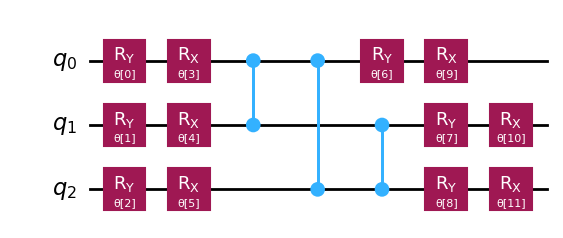

In [13]:
# ============================================================================
# 6. MODELO CUÁNTICO - VQC (Variational Quantum Classifier) MEJORADO
# ============================================================================

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_algorithms.utils import algorithm_globals

# Semilla global
algorithm_globals.random_seed = 42

backend = AerSimulator()
n_qubits = X_train.shape[1]

print("=" * 70)
print("CONFIGURACIÓN DEL MODELO VQC")
print("=" * 70)
print(f"Número de qubits: {n_qubits}")

# Feature map: Consistente con QSVM pero puede ser más simple
feature_map_vqc = ZZFeatureMap(
    feature_dimension=n_qubits,
    reps=1,  # Aumentado para mayor capacidad
    entanglement='full'  # Cambiado de 'linear' a 'full'
)

# Ansatz variacional MEJORADO: Más profundo y expresivo
ansatz_vqc = TwoLocal(
    num_qubits=n_qubits,
    rotation_blocks=['ry', 'rx'],
    entanglement_blocks='cz',
    entanglement='full',
    reps=1,  # AUMENTADO de 1 a 3 para mayor capacidad de aprendizaje
    skip_final_rotation_layer=False
)

# Información del ansatz
print(f"\nFeature Map:")
print(f"  - Tipo: ZZFeatureMap")
print(f"  - Reps: 2")
print(f"  - Entanglement: full")

print(f"\nAnsatz Variacional:")
print(f"  - Tipo: TwoLocal")
print(f"  - Rotaciones: Ry, Rz")
print(f"  - Entrelazamiento: CZ (full)")
print(f"  - Repeticiones: 3")
print(f"  - Parámetros libres: {ansatz_vqc.num_parameters}")
print(f"  - Profundidad: {ansatz_vqc.decompose().depth()}")
print(f"  - Número de puertas: {ansatz_vqc.decompose().size()}")
print("=" * 70)

# Visualizar ansatz
print("\nVisualizando Ansatz Variacional...")
ansatz_vqc.decompose().draw(output='mpl')

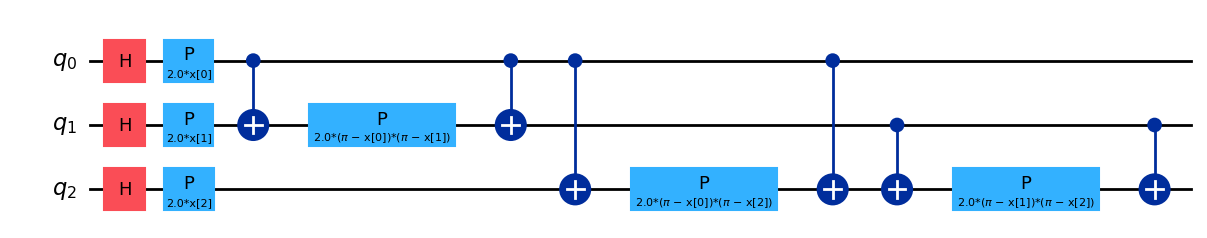

In [14]:
feature_map_vqc.decompose().draw(output='mpl')

In [15]:
# ============================================================================
# 6.1. OPTIMIZADOR PARA VQC - MEJORADO
# ============================================================================

print("=" * 70)
print("CONFIGURACIÓN DEL OPTIMIZADOR")
print("=" * 70)

# OPCIÓN 1: SPSA mejorado (Recomendado para circuitos ruidosos)
maxiter_vqc = 200  # AUMENTADO de 100 a 200 iteraciones

optimizer_vqc = SPSA(
    maxiter=maxiter_vqc,
    learning_rate=0.01,  # REDUCIDO de 0.05 a 0.01 para convergencia más estable
    perturbation=0.05    # REDUCIDO de 0.1 a 0.05 para búsqueda más fina
)

print(f"Optimizador: SPSA")
print(f"  - Max iteraciones: {maxiter_vqc}")
print(f"  - Learning rate: 0.01")
print(f"  - Perturbation: 0.05")

# OPCIÓN 2: COBYLA (Descomenta para probar alternativa)
# optimizer_vqc = COBYLA(
#     maxiter=200,
#     rhobeg=0.5
# )
# print(f"Optimizador: COBYLA")
# print(f"  - Max iteraciones: 200")
# print(f"  - rhobeg: 0.5")

# print("=" * 70)

# Callback para monitorear progreso - CORREGIDO para qiskit-machine-learning 0.7.2
# La nueva firma solo recibe: (weights, objective_value)
iteration_count = [0]  # Usar lista mutable para mantener el contador

def callback_vqc(weights, objective_value):
    iteration_count[0] += 1
    if iteration_count[0] % 20 == 0:  # Imprimir cada 20 iteraciones
        print(f"  Iteración {iteration_count[0]:3d} | Loss: {objective_value:.6f}")

# Crear modelo VQC
vqc = VQC(
    feature_map=feature_map_vqc,
    ansatz=ansatz_vqc,
    optimizer=optimizer_vqc,
    callback=callback_vqc  # Agregar callback para monitoreo
)

print("\n✓ Modelo VQC configurado y listo para entrenar")

CONFIGURACIÓN DEL OPTIMIZADOR
Optimizador: SPSA
  - Max iteraciones: 200
  - Learning rate: 0.01
  - Perturbation: 0.05

✓ Modelo VQC configurado y listo para entrenar


In [16]:
print("=" * 70)
print("ENTRENANDO MODELO VQC")
print("=" * 70)
print("Esto puede tomar varios minutos dependiendo del hardware...\n")

start_time = time.time()

# VQC espera X (features) y y (etiquetas) como en scikit-learn
vqc.fit(X_train, y_train)

vqc_train_time = time.time() - start_time
print(f"\n✓ Modelo VQC entrenado en {vqc_train_time:.2f} segundos ({vqc_train_time/60:.2f} minutos)")

# Predicciones
print("\nRealizando predicciones con VQC...")
y_pred_train_vqc = vqc.predict(X_train)
y_pred_val_vqc = vqc.predict(X_val)
y_pred_test_vqc = vqc.predict(X_test)

# Obtener scores para AUC
try:
    y_score_train_vqc = vqc.decision_function(X_train)
    y_score_val_vqc = vqc.decision_function(X_val)
    y_score_test_vqc = vqc.decision_function(X_test)
except Exception:
    try:
        y_proba_train_vqc = vqc.predict_proba(X_train)
        y_proba_val_vqc = vqc.predict_proba(X_val)
        y_proba_test_vqc = vqc.predict_proba(X_test)
        
        if y_proba_test_vqc.ndim == 2 and y_proba_test_vqc.shape[1] == 2:
            y_score_train_vqc = y_proba_train_vqc[:, 1]
            y_score_val_vqc = y_proba_val_vqc[:, 1]
            y_score_test_vqc = y_proba_test_vqc[:, 1]
        else:
            y_score_train_vqc = y_proba_train_vqc.ravel()
            y_score_val_vqc = y_proba_val_vqc.ravel()
            y_score_test_vqc = y_proba_test_vqc.ravel()
    except Exception:
        y_score_train_vqc = None
        y_score_val_vqc = None
        y_score_test_vqc = None

# Métricas
acc_train_vqc = accuracy_score(y_train, y_pred_train_vqc)
acc_val_vqc = accuracy_score(y_val, y_pred_val_vqc)
acc_test_vqc = accuracy_score(y_test, y_pred_test_vqc)

if y_score_test_vqc is not None:
    auc_train_vqc = roc_auc_score(y_train, y_score_train_vqc)
    auc_val_vqc = roc_auc_score(y_val, y_score_val_vqc)
    auc_test_vqc = roc_auc_score(y_test, y_score_test_vqc)
else:
    auc_train_vqc = None
    auc_val_vqc = None
    auc_test_vqc = None

print("\n" + "="*70)
print("RESULTADOS MODELO VQC")
print("="*70)
print(f"  - Accuracy (Train): {acc_train_vqc:.4f} {'✓' if acc_train_vqc >= acc_train_cl else '✗'}")
print(f"  - Accuracy (Val):   {acc_val_vqc:.4f} {'✓' if acc_val_vqc >= acc_val_cl else '✗'}")
print(f"  - Accuracy (Test):  {acc_test_vqc:.4f} {'✓' if acc_test_vqc >= acc_test_cl else '✗'}")

if auc_test_vqc is not None:
    print(f"  - AUC (Train):      {auc_train_vqc:.4f}")
    print(f"  - AUC (Val):        {auc_val_vqc:.4f} {'✓' if auc_val_vqc >= auc_val_cl else '✗'}")
    print(f"  - AUC (Test):       {auc_test_vqc:.4f} {'✓' if auc_test_vqc >= auc_test_cl else '✗'}")
else:
    print("  - AUC: No disponible (sin scores continuos)")

print(f"  - Tiempo:           {vqc_train_time:.2f}s")
print("="*70)

# Comparación con baseline
if auc_test_vqc is not None:
    diff_acc_vqc = acc_test_vqc - acc_test_cl
    diff_auc_vqc = auc_test_vqc - auc_test_cl
    print(f"\nComparación con baseline clásico:")
    print(f"  - Δ Accuracy: {diff_acc_vqc:+.4f} ({diff_acc_vqc/acc_test_cl*100:+.2f}%)")
    print(f"  - Δ AUC:      {diff_auc_vqc:+.4f} ({diff_auc_vqc/auc_test_cl*100:+.2f}%)")

ENTRENANDO MODELO VQC
Esto puede tomar varios minutos dependiendo del hardware...

  Iteración  20 | Loss: 1.108011
  Iteración  40 | Loss: 1.127476
  Iteración  60 | Loss: 1.114041
  Iteración  80 | Loss: 1.096593
  Iteración 100 | Loss: 1.123804
  Iteración 120 | Loss: 1.092365
  Iteración 140 | Loss: 1.091304
  Iteración 160 | Loss: 1.104614
  Iteración 180 | Loss: 1.113479
  Iteración 200 | Loss: 1.098586
  Iteración 220 | Loss: 1.083148
  Iteración 240 | Loss: 1.078124
  Iteración 260 | Loss: 1.100387
  Iteración 280 | Loss: 1.081881
  Iteración 300 | Loss: 1.091451
  Iteración 320 | Loss: 1.060933
  Iteración 340 | Loss: 1.086550
  Iteración 360 | Loss: 1.067154
  Iteración 380 | Loss: 1.059691
  Iteración 400 | Loss: 1.079714

✓ Modelo VQC entrenado en 366.16 segundos (6.10 minutos)

Realizando predicciones con VQC...

RESULTADOS MODELO VQC
  - Accuracy (Train): 0.4767 ✗
  - Accuracy (Val):   0.4000 ✗
  - Accuracy (Test):  0.4800 ✗
  - AUC: No disponible (sin scores continuos)
 

In [17]:
print("\n" + "="*80)
print("COMPARACIÓN FINAL: CLÁSICO vs QSVM vs VQC")
print("="*80)

print(f"\nCONFIGURACIÓN DEL EXPERIMENTO:")
print(f"  - Muestras entrenamiento: {len(X_train)}")
print(f"  - Muestras test: {len(X_test)}")
print(f"  - Features utilizados: {n_qubits}")
print(f"  - Features seleccionados: {selected_features}")

print("\n" + "-" * 100)
print(f"{'Métrica':<25} {'Clásico (SVM-RBF)':<25} {'QSVM':<25} {'VQC':<25}")
print("-" * 100)
print(f"{'Accuracy (Train)':<25} {acc_train_cl:<25.4f} {acc_train_q:<25.4f} {acc_train_vqc:<25.4f}")
print(f"{'Accuracy (Val)':<25} {acc_val_cl:<25.4f} {acc_val_q:<25.4f} {acc_val_vqc:<25.4f}")
print(f"{'Accuracy (Test)':<25} {acc_test_cl:<25.4f} {acc_test_q:<25.4f} {acc_test_vqc:<25.4f}")

auc_test_vqc_display = auc_test_vqc if auc_test_vqc is not None else float('nan')
auc_val_vqc_display = auc_val_vqc if auc_val_vqc is not None else float('nan')

print(f"{'AUC (Val)':<25} {auc_val_cl:<25.4f} {auc_val_q:<25.4f} {auc_val_vqc_display:<25.4f}")
print(f"{'AUC (Test)':<25} {auc_test_cl:<25.4f} {auc_test_q:<25.4f} {auc_test_vqc_display:<25.4f}")
print(f"{'Tiempo (s)':<25} {classical_train_time:<25.2f} {qsvm_train_time:<25.2f} {vqc_train_time:<25.2f}")
print("-" * 100)

# Análisis detallado
print("\n" + "="*80)
print("ANÁLISIS COMPARATIVO")
print("="*80)

# Comparación de Accuracy
best_acc = max(acc_test_cl, acc_test_q, acc_test_vqc)
models = {'Clásico': acc_test_cl, 'QSVM': acc_test_q, 'VQC': acc_test_vqc}
best_model_acc = max(models, key=models.get)

print(f"\n✓ MEJOR ACCURACY: {best_model_acc} con {best_acc:.4f}")
for model, acc in models.items():
    diff = acc - acc_test_cl
    percentage = (diff / acc_test_cl * 100) if acc_test_cl > 0 else 0
    symbol = "🏆" if model == best_model_acc else "  "
    print(f"  {symbol} {model:<12} {acc:.4f} (Δ: {diff:+.4f}, {percentage:+.2f}%)")

# Comparación de AUC
if auc_test_vqc is not None:
    best_auc = max(auc_test_cl, auc_test_q, auc_test_vqc)
    models_auc = {'Clásico': auc_test_cl, 'QSVM': auc_test_q, 'VQC': auc_test_vqc}
    best_model_auc = max(models_auc, key=models_auc.get)
    
    print(f"\n✓ MEJOR AUC: {best_model_auc} con {best_auc:.4f}")
    for model, auc_val in models_auc.items():
        diff = auc_val - auc_test_cl
        percentage = (diff / auc_test_cl * 100) if auc_test_cl > 0 else 0
        symbol = "🏆" if model == best_model_auc else "  "
        print(f"  {symbol} {model:<12} {auc_val:.4f} (Δ: {diff:+.4f}, {percentage:+.2f}%)")

# Eficiencia computacional
print(f"\n✓ EFICIENCIA TEMPORAL:")
print(f"  - Clásico: {classical_train_time:.2f}s (1.00x)")
print(f"  - QSVM:    {qsvm_train_time:.2f}s ({qsvm_train_time/classical_train_time:.2f}x)")
print(f"  - VQC:     {vqc_train_time:.2f}s ({vqc_train_time/classical_train_time:.2f}x)")

print("\n" + "="*80)


COMPARACIÓN FINAL: CLÁSICO vs QSVM vs VQC

CONFIGURACIÓN DEL EXPERIMENTO:
  - Muestras entrenamiento: 300
  - Muestras test: 100
  - Features utilizados: 3
  - Features seleccionados: ['lepton1_pT', 'missing_energy_magnitude', 'M_TR_2']

----------------------------------------------------------------------------------------------------
Métrica                   Clásico (SVM-RBF)         QSVM                      VQC                      
----------------------------------------------------------------------------------------------------
Accuracy (Train)          0.7700                    0.7767                    0.4767                   
Accuracy (Val)            0.7900                    0.7400                    0.4000                   
Accuracy (Test)           0.8600                    0.8200                    0.4800                   
AUC (Val)                 0.8324                    0.7912                    nan                      
AUC (Test)                0.9296       


REPORTE DETALLADO - MODELOS CUÁNTICOS

--------------------------------------------------------------------------------
MATRIZ DE CONFUSIÓN - QSVM
--------------------------------------------------------------------------------
[[45  5]
 [13 37]]

Reporte de Clasificación:
              precision    recall  f1-score   support

   Fondo (0)       0.78      0.90      0.83        50
   Señal (1)       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100


--------------------------------------------------------------------------------
MATRIZ DE CONFUSIÓN - VQC
--------------------------------------------------------------------------------
[[19 31]
 [21 29]]

Reporte de Clasificación:
              precision    recall  f1-score   support

   Fondo (0)       0.47      0.38      0.42        50
   Señal (1)       0.48      0.58      0.53        50


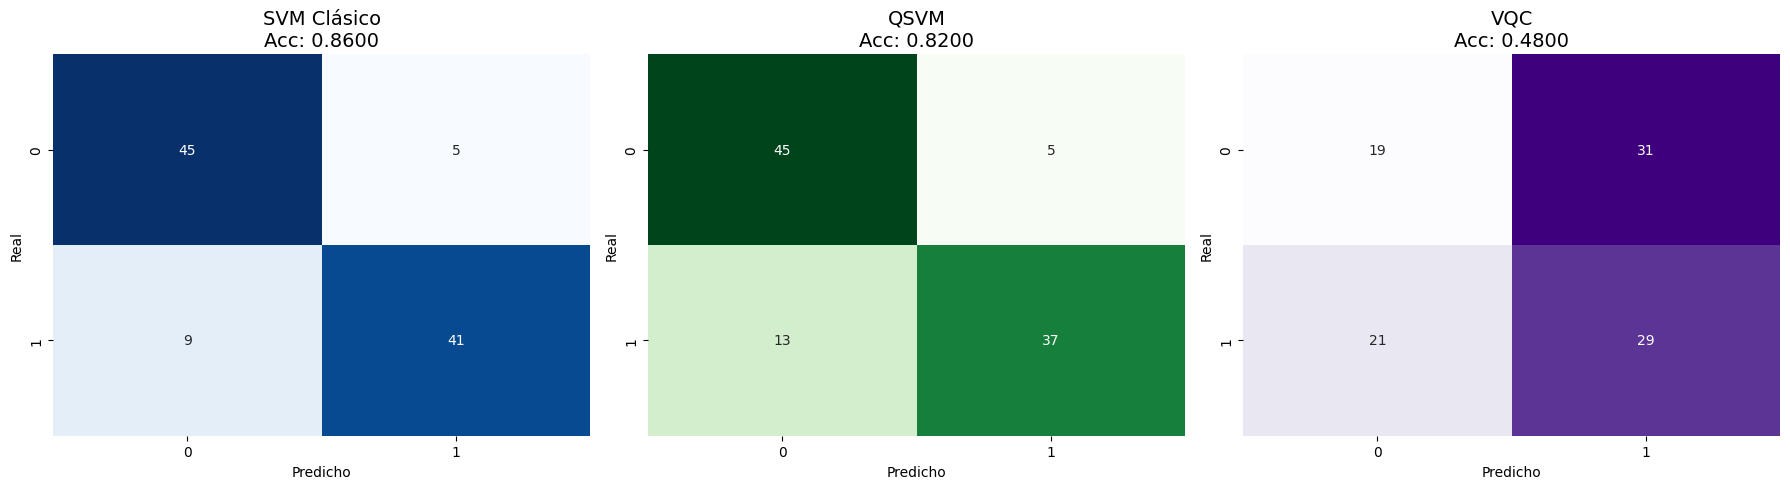

In [18]:
print("\n" + "="*80)
print("REPORTE DETALLADO - MODELOS CUÁNTICOS")
print("="*80)

# Matrices de confusión
from sklearn.metrics import confusion_matrix, classification_report

print("\n" + "-"*80)
print("MATRIZ DE CONFUSIÓN - QSVM")
print("-"*80)
cm_qsvm = confusion_matrix(y_test, y_pred_test_q)
print(cm_qsvm)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_test_q, target_names=['Fondo (0)', 'Señal (1)']))

print("\n" + "-"*80)
print("MATRIZ DE CONFUSIÓN - VQC")
print("-"*80)
cm_vqc = confusion_matrix(y_test, y_pred_test_vqc)
print(cm_vqc)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_test_vqc, target_names=['Fondo (0)', 'Señal (1)']))

# Visualización de matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Clásico
sns.heatmap(confusion_matrix(y_test, y_pred_test_cl), annot=True, fmt='d', 
            cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title(f'SVM Clásico\nAcc: {acc_test_cl:.4f}', fontsize=14)
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

# QSVM
sns.heatmap(cm_qsvm, annot=True, fmt='d', 
            cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title(f'QSVM\nAcc: {acc_test_q:.4f}', fontsize=14)
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

# VQC
sns.heatmap(cm_vqc, annot=True, fmt='d', 
            cmap='Purples', ax=axes[2], cbar=False)
axes[2].set_title(f'VQC\nAcc: {acc_test_vqc:.4f}', fontsize=14)
axes[2].set_xlabel('Predicho')
axes[2].set_ylabel('Real')

plt.tight_layout()
plt.show()

print("="*80)